# 连接数据库

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CPU times: user 11.1 s, sys: 299 ms, total: 11.4 s
Wall time: 11.5 s


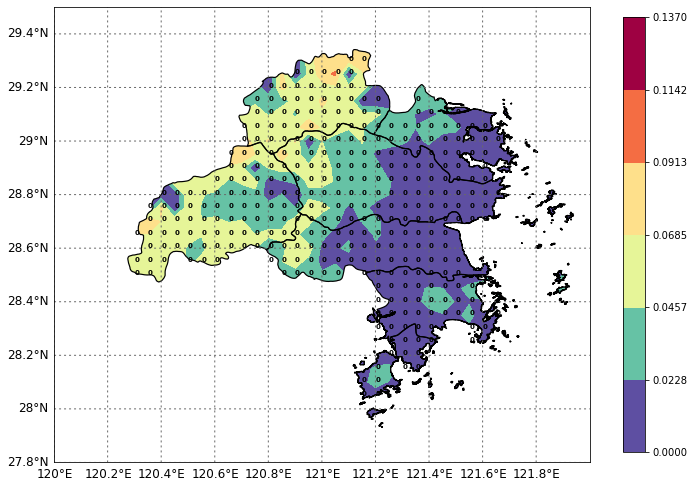

In [8]:
%%time
import gevent
from math import isnan
import numpy as np
#import modin.pandas as pd 
import pandas as pd
import time
from func import *
import matplotlib
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import json
import math

import pymssql 
pd.set_option('mode.chained_assignment', None)


class sql_data:
    def __init__(self, start,end):
        # station_Mws = pd.read_csv("Mws_15.csv")
        # station_Aws = pd.read_csv("Aws_15.csv")
        # self.station_all = pd.concat([station_Aws, station_Mws])
        # self.sql = sql  # 传进来的参数
        # 数据库初始化
        self.start = start
        self.end = end
        self.server = "172.21.158.201"    # 连接服务器地址
        self.user = "down"# 连接帐号
        self.password = "downx"# 连接密码
        self.station_all = self.sql_comput()        
        # 数据
        self.grouped_county = self.station_all.groupby('county')
        self.grouped_IIiii = self.station_all.groupby('IIiii')
        self.timecounts = 30#len(self.grouped_IIiii.get_group(58660)['tTime'])
        # 统计变量.station_RR_small = 0.0
        self.station_RR_small = 0.0
        self.station_RR_mid = 0.0
        self.station_RR_big = 0.0
        self.station_RR_huge = 0.0
        self.station_RR_bighuge = 0.0
        self.station_RR_more = 0.0

        self.station_wind7 = 0.0
        self.station_wind8 = 0.0
        self.station_wind9 = 0.0
        self.station_wind10 = 0.0
        self.station_wind11 = 0.0
        self.station_wind12 = 0.0
        self.station_wind13 = 0.0
        self.station_wind14 = 0.0
        self.station_wind15 = 0.0
        self.station_wind16 = 0.0
        self.station_wind17 = 0.0

        self.station_VV_small = 0.0
        self.station_VV_mid = 0.0
        self.station_VV_big = 0.0
        self.station_VV_huge = 0.0
        self.station_VV_more = 0.0
        # 分级
        self.RR_rank = []
        self.fFy_rank = []
        # 散点
        self.data_station = []
        # 单站
        self.station_list = {}
        self.symbol_ffy = ['path://M10 10L50 10 50 20 20 20 20 40 50 40 50 50 20 50 20 100 10 100 10 10z']
        self.vv_min_name = ""
        self.vv_min_value = 9999
        # 绘图和排序
        self.plot_data = {
            'IIiii':[],
            'lat':[],
            'lon':[],
            'county':[],
            'town':[],
            'name':[],
            'fFy':[],
            'dFy':[],
            'rsum':[],
            'tmax':[],
            'tmin':[],
            'rmax':[]
            }
    def month_strto_num(self,start_month):
        monlist = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        if start_month =='Jan':
            month = '01'
        elif start_month =='Feb':
            month = '02'
        elif start_month =='Mar':
            month = '03'
        elif start_month =='Apr':
            month = '04'
        elif start_month =='May':
            month = '05'
        elif start_month =='Jun':
            month = '06'
        elif start_month =='Jul':
            month = '07'
        elif start_month =='Aug':
            month = '08'
        elif start_month =='Sep':
            month = '09'
        elif start_month =='Oct':
            month = '10'
        elif start_month =='Nov':
            month = '11'
        elif start_month =='Dec':
            month = '12'
        return month

    def sql_comput(self):
        start_year = self.start[11:15]
        start_day = self.start[8:10]
        start_hour = self.start[16:18]
        start_min = self.start[19:21]
        start_month = self.month_strto_num(self.start[4:7])
        end_year = self.end[11:15]
        end_day = self.end[8:10]
        end_hour = self.end[16:18]
        end_min = self.end[19:21]
        end_month = self.month_strto_num(self.end[4:7])
        time1 = str(start_year+"-"+start_month+"-"+start_day+" "+start_hour+":"+start_min +":00" )
        time2 = str(end_year+"-"+end_month+"-"+end_day+" "+end_hour+":"+end_min +":00" )
        if start_year == end_year:
            sql = "select b.StationName,b.county,b.Town,b.lat,b.lon,b.IIiii,tTime,dFy,fFy,T,Tx,Tn,VV,RR from TAB_Mws"+\
                start_year+" as a left join TAB_StationInfo as b on a.IIiii=b.IIiii where "\
                +"(b.IIiii in (select IIiii from TAB_StationInfo where(City = '台州') and tTime between "+\
                "'"+time1+ "'" +" and " + "'"+time2+ "'" + '))' + ' union all '\
                "select b.StationName,b.county,b.Town,b.lat,b.lon,b.IIiii,tTime,dFy,fFy,T,Tx,Tn,VV,RR from TAB_Aws"+\
                start_year+" as a left join TAB_StationInfo as b on a.IIiii=b.IIiii where "\
                +"(b.IIiii in (select IIiii from TAB_StationInfo where(City = '台州') and tTime between "+\
                "'"+time1+ "'" +" and " + "'"+time2+ "'" + '))'
            conn = pymssql.connect(self.server, self.user, self.password, "ZJSZDZDB")  #获取连接
            df_location = pd.read_sql(sql , con=conn)
        return df_location

    def comput_county(self):
        '计算面最大雨强、累计降水、最高、最低气温'
        self.station_county_comput = []
        for i in self.grouped_county.size().index:  
            data= self.grouped_county.get_group(i)
            data['VV'].replace(-9999,np.nan,inplace=True)
            data['RR'].replace(-9999,np.nan,inplace=True)
            data['Tn'].replace(-9999,np.nan,inplace=True)
            data['Tx'].replace(-9999,np.nan,inplace=True)
            dic = {}
            dic['county'] = str(i)
            dic['RR'] = data['RR'].mean()*self.timecounts/10.0
            dic['RMax'] = data['RR'].max()/10.0
            dic['Tx'] = data['Tx'].max()/10.0
            dic['Tn'] = data['Tn'].min()/10.0 
#             print(dic)
            self.station_county_comput.append(dic)
        tmp_max_County = []
        tmp_min_County = []
        RR_County = []
        for i in self.station_county_comput:
            tmp_max_County.append({"name":i['county'],"value":i['Tx']})
            tmp_min_County.append({"name":i['county'],"value":i['Tn']})
            RR_County.append({"name":i['county'],"value":i['RR']})
        return RR_County,tmp_max_County,tmp_min_County
    def data_gevent(self,data):
        # print("data_gevent")
        nan_del = lambda x: 9999 if np.isnan(x) else x 
        value_rsum = data['RR'].sum()/10.0
        value_rmax = data['RR'].sum()/10.0
        fFy_data = data['fFy'].max()/10.0
        dFy_data = data[data['fFy'] == data['fFy'].max()]['dFy'].iloc[0]
        value_VV = nan_del(data['VV'].min())
        value_tmax = nan_del(data['Tx'].max()/10.0)
        value_tmin = nan_del(data['Tn'].min()/10.0)
        # print("查看数据：",print(type(value_VV)),value_VV)



        if value_rsum >= 0 and value_rsum < 10:
            self.station_RR_small = self.station_RR_small + 0
        elif value_rsum >= 9 and value_rsum < 25:
            self.station_RR_mid = self.station_RR_mid+0
        elif value_rsum >= 24 and value_rsum < 50:
            self.station_RR_big = self.station_RR_big + 0
        elif value_rsum >= 49 and value_rsum < 100:
            self.station_RR_huge = self.station_RR_huge+0
        elif value_rsum >= 99 and value_rsum < 250:
            self.station_RR_RR_bighuge = self.station_RR_bighuge+0
        else:
            self.station_RR_more = self.station_RR_more+0
        # 大风


        if fFy_data > 12.8 and fFy_data <= 17.1:
            self.station_wind6 = self.station_wind7 + 1
        elif fFy_data > 16.1 and fFy_data <= 20.7:
            self.station_wind7 = self.station_wind8 + 1
        elif fFy_data > 19.7 and fFy_data <= 24.4:
            self.station_wind8 = self.station_wind9 + 1
        elif fFy_data > 23.4 and fFy_data <= 28.4:
            self.station_wind9 = self.station_wind10 + 1
        elif fFy_data > 27.4 and fFy_data <= 32.6:
            self.station_wind10 = self.station_wind11 + 1
        elif fFy_data > 31.6 and fFy_data <= 36.9:
            self.station_wind11 = self.station_wind12 + 1
        elif fFy_data > 35.9 and fFy_data <= 41.4:
            self.station_wind12 = self.station_wind13 + 1
        elif fFy_data > 40.4 and fFy_data <= 46.1:
            self.station_wind13 = self.station_wind14 + 1
        elif fFy_data > 45.1 and fFy_data <= 51.0:
            self.station_wind14 = self.station_wind15 + 1
        elif fFy_data > 50.0 and fFy_data <= 56.1:
            self.station_wind15 = self.station_wind16 + 1
        else:
            self.station_wind16 = self.station_wind17 + 1

        # 能见度
        if value_VV< self.vv_min_value:
            self.vv_min_value = value_VV
            self.vv_min_name = str(data['IIiii'].iloc[0])
        if value_VV >= 0 and value_VV < 50:
            self.station_VV_small = self.station_VV_small + 0
        elif value_VV >= 49 and value_VV < 200:
            self.station_VV_mid = self.station_VV_mid+0
        elif value_VV >= 199 and value_VV < 500:
            self.station_VV_big = self.station_VV_big + 0
        elif value_VV >= 499 and value_VV < 1000:
            self.station_VV_huge = self.station_VV_huge+0
        else:
            self.station_VV_more = self.station_VV_more+0
        # 绘图、排序数据
        self.plot_data['IIiii'].append(data['IIiii'].iloc[0])  
        self.plot_data['lat'].append(data['lat'].iloc[0]) 
        self.plot_data['lon'].append(data['lon'].iloc[0])
        self.plot_data['county'].append(data['county'].iloc[0])
        self.plot_data['town'].append(data['Town'].iloc[0])
        self.plot_data['name'].append(data['StationName'].iloc[0])
        self.plot_data['fFy'].append(fFy_data)
        self.plot_data['dFy'].append(dFy_data)
        self.plot_data['rsum'].append(value_rsum/10.0)
        self.plot_data['rmax'].append(data['RR'].max()/10.0)
        self.plot_data['tmax'].append(value_tmax)
        self.plot_data['tmin'].append(value_tmin)


       
        self.dic_station = {'IIiii': data['IIiii'].iloc[0],
                   'StationName': data['StationName'].iloc[0],
                   'County': data['county'].iloc[0],
                   'Town': data['Town'].iloc[0],
                   'lat': data['lat'].iloc[0],
                   'lon': data['lon'].iloc[0],
                   'rsum': value_rsum/10.0,
                   'rmax': data['RR'].max()/10.0,
                   'tmax': value_tmax,
                   'tmin': value_tmin,
                   'vmin': value_VV,
                   'fmax': fFy_data,
                   'dfx': data[data['fFy'] == data['fFy'].min()]['dFy'].iloc[0],
                #    'label_rsm': value_rsum/10.0,
                #    'label_tx': data['RR'].max()/10.0,
                #    'label_tn': data['Tn'].min()/10.0,
                #    'label_tworn': data['StationName'].iloc[0],
                #    'label_v': data['VV'].min(),
                #    'label_fy': data['StationName'].iloc[0],
                   'url_r': "station/"+str(data['IIiii'].iloc[0])+"/rain/",
                   'url_t': "station/"+str(data['IIiii'].iloc[0])+"/temp/",
                   'url_v': "station/"+str(data['IIiii'].iloc[0])+"/vv/",
                   'url_fy': "station/"+str(data['IIiii'].iloc[0])+"/fFy/",
                   'name': data['StationName'].iloc[0],

                   'value':[
                       data['lon'].iloc[0],
                       data['lat'].iloc[0],
                       value_rsum,
                       value_rmax,
                       value_VV,
                       fFy_data,
                       value_tmax,
                       value_tmin
                   ]
                #    'symbol':str(self.symbol_ffy[0]) ,
                #    'symbolRotate':data[data['fFy'] == data['fFy'].min()]['dFy'].iloc[0],

                   }
        # self.data_station = self.data_station.append(self.dic_station, ignore_index=True)
        self.data_station.append(self.dic_station)
        self.station_list_dir = {
            'name':data['StationName'].iloc[0],
            'rmax': data['RR'].max()/10.0,
            'rsum':value_rsum/10.0,
            # 'tmax':[],
            # 'tmin':[],
            'time': data['tTime'].tolist(),
            'T': data['T'].tolist(),
            'V': data['VV'].tolist(),
            'fFy': data['fFy'].tolist(),
            'dFy': data['dFy'].tolist()
        }
        self.station_list[str(data['IIiii'].iloc[0])] = self.station_list_dir
        # print(self.data_station)
        
        
        # return station_list,data_station
    def read_shp_json(self):
        with open('../json/taizhou.json', encoding='utf-8') as f:
            line = f.readline()
            tz_json = json.loads(line)
            tz_json = json.dumps(tz_json)
            f.close()
        return tz_json

    def comput_IIiii(self):
        '返回pandas、字典串、列表'

        # print("运行commput")



        for i in self.grouped_IIiii.size().index:
            # print("i:",i)
            data = self.grouped_IIiii.get_group(i)
            data['VV'].replace(-9999, np.nan, inplace=True)
            data['RR'].replace(-9999, np.nan, inplace=True)
            data['Tn'].replace(-9999, np.nan, inplace=True)
            data['Tx'].replace(-9999, np.nan, inplace=True)
            self.data_gevent(data)
        self.RR_rank = [
            self.station_RR_small,
            self.station_RR_mid,
            self.station_RR_big,
            self.station_RR_huge,
            self.station_RR_bighuge,
            self.station_RR_more
            ]
        self.fFy_rank = [
            self.station_wind7,
            self.station_wind8,
            self.station_wind9,
            self.station_wind10,
            self.station_wind11,
            self.station_wind12,
            self.station_wind13,
            self.station_wind14,
            self.station_wind15,
            self.station_wind16,
            self.station_wind17     
        ]
        self.vv_rank = [
            self.station_VV_small,
            self.station_VV_mid,
            self.station_VV_big,
            self.station_VV_huge
        ]

            # g = gevent.spawn(data_gevent, data)
    # 数据排序
    def return_data_sort(self,sort_data,value_str):
        max_sort = max(sort_data[value_str])
        level_sort = np.linspace(start = 0.0, stop = max_sort, num = 9)
        sort_da = pd.DataFrame(sort_data)
        if value_str == "rsum" or 'rmax':
            sort_da['index'] = sort_da[value_str].rank(ascending=0,method='dense')
            sort_out = sort_da.sort_values(by =[value_str],ascending = [False])  
            list_data = []
            for row in sort_out.itertuples():
                dic_iter = {'index':int(getattr(row, 'index')),'IIiii':str(getattr(row, 'name')),
                    'county':getattr(row, 'county'),'town':getattr(row, 'town'),'data':getattr(row, value_str),
                    'value':[getattr(row, 'lon'),getattr(row, 'lat'),getattr(row,value_str)]}
                list_data.append(dic_iter)
        if value_str == "fFy":
            sort_da['index'] = sort_da[value_str].rank(ascending=0,method='dense')
            sort_out = sort_da.sort_values(by =[value_str],ascending = [False])  
            list_data = []
            for row in sort_out.itertuples():
                dic_iter = {'index':int(getattr(row, 'index')),'IIiii':str(getattr(row, 'name')),
                    'county':getattr(row, 'county'),'town':getattr(row, 'town'),'data':getattr(row, value_str),
                    'value':[getattr(row, 'lon'),getattr(row, 'lat'),getattr(row,value_str)],
                    'symbol':str(self.symbol_ffy[0]),
                    'symbolRotate':getattr(row, 'dFy')
                    }
                list_data.append(dic_iter)
        return list_data ,level_sort
    # 数据绘图

    def plot_imd(self, plot_data, value_str):
        # value_str = 'rsum'
        lat = plot_data['lat']
        lon = plot_data['lon']
        value = plot_data[value_str]
        plot_image(lat,lon,value)
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd
    # 返回第一个页面的回调数据
    def data_output(self):
        # 排序
        RR_sum ,level_rain= self.return_data_sort(self.plot_data,'rsum')
        RR_rx,level_rmax = self.return_data_sort(self.plot_data,'rmax')
        data_fFy_list,level_fFy = self.return_data_sort(self.plot_data,'fFy')
        # 柱状图
        RR_station_rank = self.RR_rank
        nation_station = ['58660','58666','K8505','K8206','58559','K8271','58662','58653']
        tmp_station_bar = []
        tmp_station_bar.append(['product', '最高气温','最低气温'])
        RR_station_bar = []
        RR_station_bar.append(['product', '累计降水','最大雨强'])
        # 计算指标站nation_station的要素值 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        for i in nation_station:
            # print(i)
            var_name = str(self.station_list[i]['name'])
            var_tmax = max(self.station_list[i]['T'])/10.0
            var_tmin = min(self.station_list[i]['T'])/10.0
            var_rsum = self.station_list[i]['rsum']
            var_rmax = self.station_list[i]['rmax']
            tmp_station_bar.append( [var_name,var_tmax,var_tmin])
            RR_station_bar.append( [var_name,var_rsum,var_rmax])
        # 散点图
        tmp_min_scatter = self.data_station
        tmp_max_scatter = self.data_station
        tmp_event_scatter = self.data_station
        VV_min_scatter = self.data_station
        fFy_wind7up_scatter = data_fFy_list
        # print(fFy_wind7up_scatter)
        # fFy_wind7up_scatter = self.data_station
        # 要素极值站点序列数据
        vv_time =  self.station_list[self.vv_min_name]['time']
        vv_value = self.station_list[self.vv_min_name]['V']
        data_vvmin =  pd.DataFrame()
        data_vvmin['tTime']= vv_time
        data_vvmin['VV']= vv_value
        data_vvmin.sort_values(by = 'tTime')
        tz_json =  self.read_shp_json()
        imd = self.plot_imd(self.plot_data,'rsum')
        # imd_tmax = self.plot_imd(self.plot_data,'tmax')
        # imd_tmin = self.plot_imd(self.plot_data,'tmin')
        



        return imd,tz_json,RR_sum ,RR_rx,level_rain,RR_station_rank,RR_station_bar,tmp_min_scatter,tmp_max_scatter,tmp_event_scatter,tmp_station_bar,VV_min_scatter,fFy_wind7up_scatter,vv_time,vv_value,data_fFy_list




start =  'Wed Mar 01 2022 19:18:00 GMT+0800 (中国标准时间)'
end = 'Wed Mar 03 2022 23:18:00 GMT+0800 (中国标准时间)'

sql_worker = sql_data(start,end)
RR_County,tmp_max_County,tmp_min_County =  sql_worker.comput_county() 
sql_worker.comput_IIiii()
imd,tz_json,RR_sum ,RR_rx,level_rain,RR_station_rank,RR_station_bar,tmp_min_scatter,tmp_max_scatter,tmp_event_scatter,tmp_station_bar,VV_min_scatter,fFy_wind7up_scatter,vv_time,vv_value,data_fFy_list = sql_worker.data_output()
print(RR_station_rank)




# BUG分析